# Investigate snow drift

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [124]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km/'

In [130]:
ds1 = xr.open_dataset(path+'HMA_SR_D_v01_100km_WY1999_00_SD_POST.nc')
ds1

<xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 366)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2000-09-30
Data variables:
    SD_Post  (time, lat, lon) float32 ...

In [135]:
u.get_human_readable_size(ds1.SD_Post.size)

'283 KB'

In [131]:
ds2 = xr.open_dataset(path+'HMA_SR_D_v01_100km_WY1999_00_SWE_SCA_POST.nc')
ds2

<xarray.Dataset>
Dimensions:   (lat: 18, lon: 44, time: 366)
Coordinates:
  * lat       (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 41.5 42.5 43.5 44.5
  * lon       (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * time      (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2000-09-30
Data variables:
    SWE_Post  (time, lat, lon) float32 ...
    SCA_Post  (time, lat, lon) float32 ...

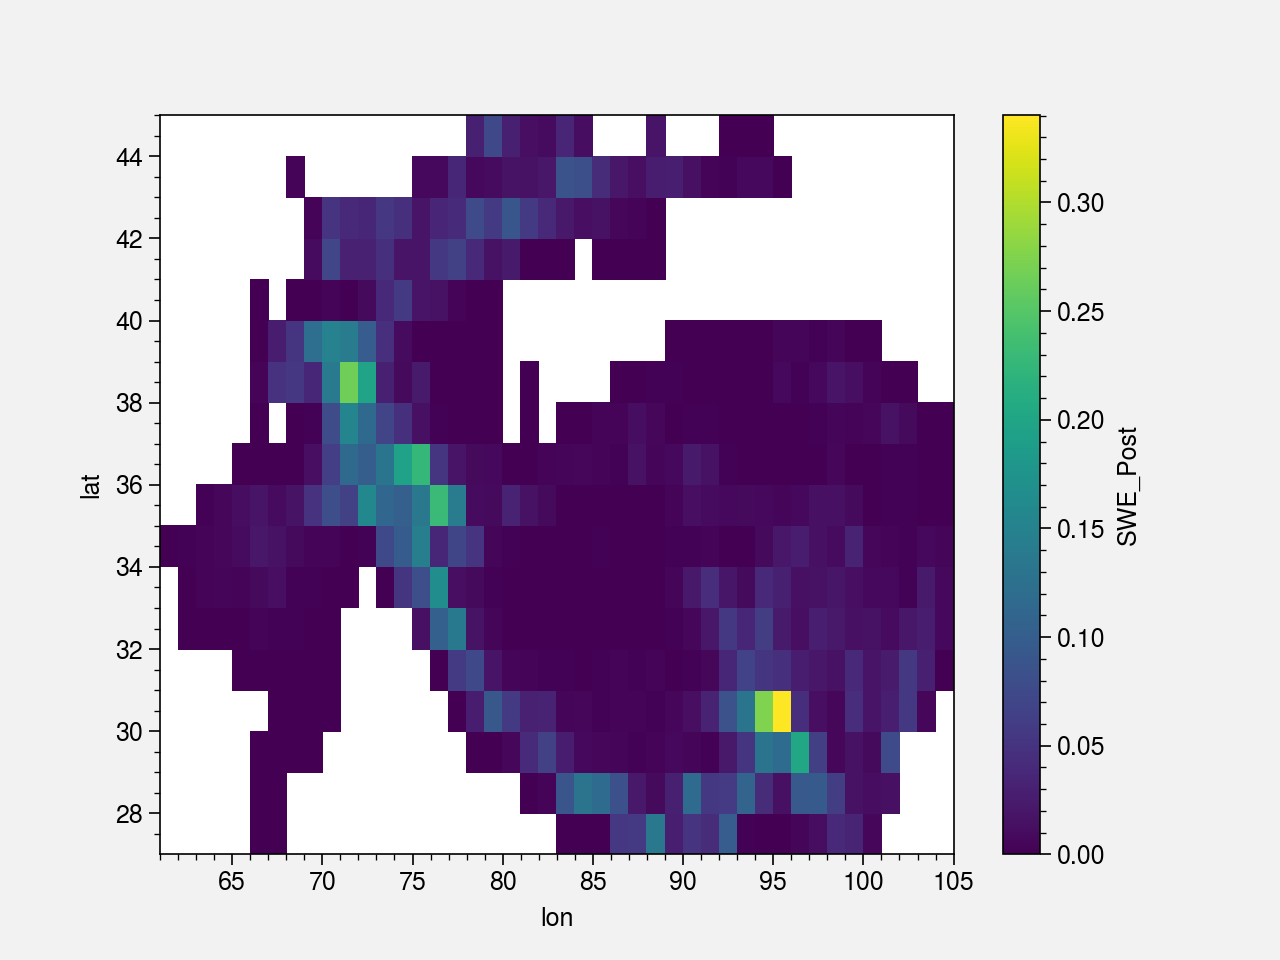

In [140]:
ds2.SWE_Post.mean('time').plot()

In [137]:
u.get_human_readable_size(ds2.SWE_Post.size)

'283 KB'

In [142]:
ds2.to_netcdf('test.nc')

In [ ]:
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SD_POST.nc')
sd = ds.SD_Post.load()

ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SWE_SCA_POST.nc')
swe = ds.SWE_Post.load()
sca = ds.SCA_Post.load()

In [62]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km/'

ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SD_POST.nc')
sd = ds.SD_Post.load()

ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SWE_SCA_POST.nc')
swe = ds.SWE_Post.load()
sca = ds.SCA_Post.load()

# Round lat/lon
sd['lat'] = np.round(sd.lat, 1) ; sd['lon'] = np.round(sd.lon, 1)
swe['lat'] = np.round(swe.lat, 1) ; swe['lon'] = np.round(swe.lon, 1)
sca['lat'] = np.round(sca.lat, 1) ; sca['lon'] = np.round(sca.lon, 1)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


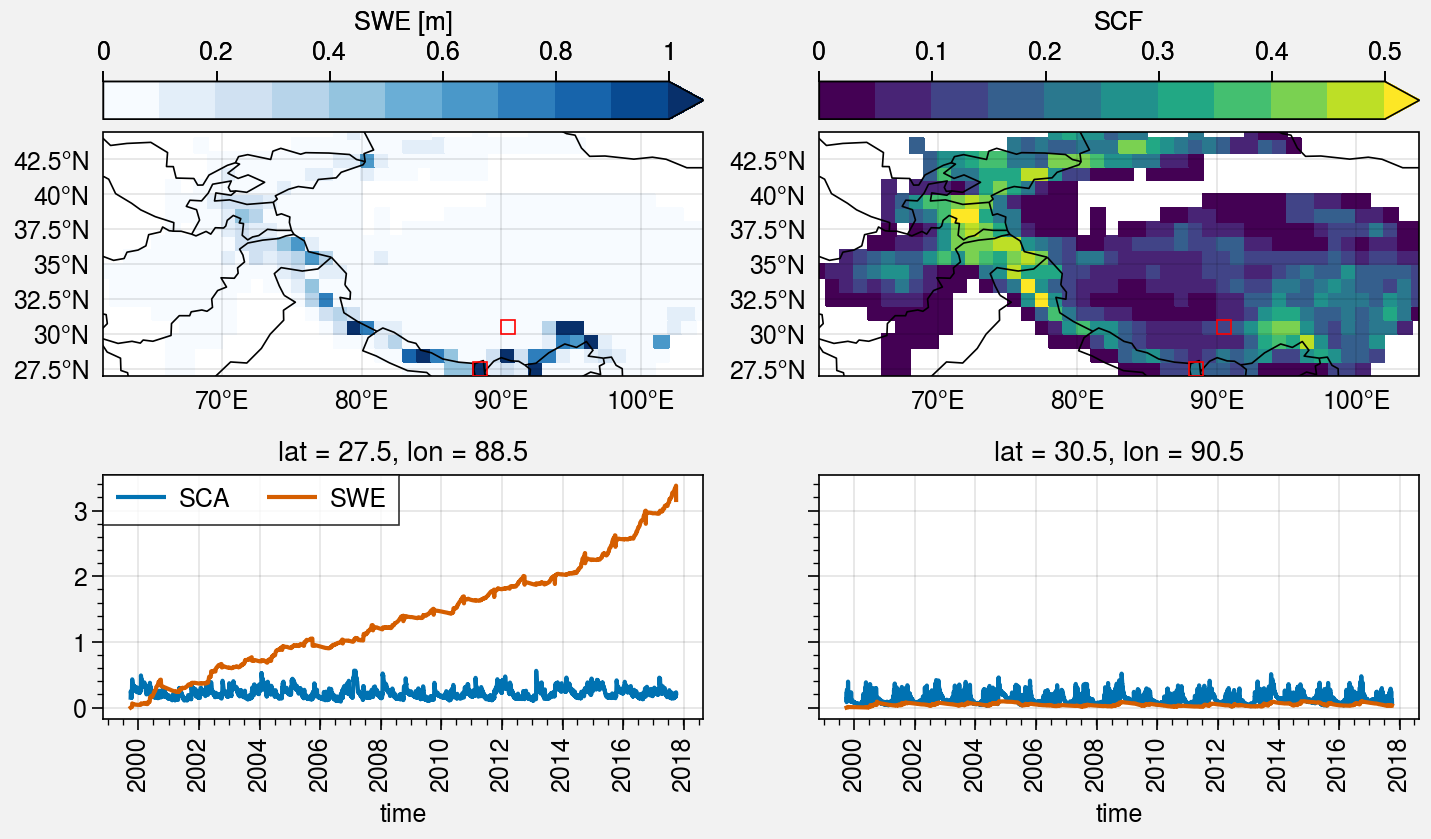

In [63]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

fig, axs = plot.subplots([[1, 1, 2, 2], [3, 3, 4, 4]], aspect=2, proj=('cyl', 'cyl'), axwidth=3, sharex=0)

ax = axs[0]
m = ax.pcolormesh(swe.mean('time'), cmap='Blues', levels=plot.arange(0, 1, 0.1), extend='max')
ax.colorbar(m, loc='t', label='SWE [m]')

ax = axs[1]
m = ax.pcolormesh(sca.mean('time'), cmap='viridis', levels=plot.arange(0, 0.5, 0.05), extend='max')
ax.colorbar(m, loc='t', label='SCF')

for ax in [axs[0], axs[1]]:
    ax.format(
        labels=True, borders=True,
        latlim=(swe.lat.min()-0.5, swe.lat.max()),
        lonlim=(swe.lon.min(), swe.lon.max()),
    )
    
    ax.add_patch(mpatches.Rectangle(xy=[88, 27], width=1, height=1, transform=ccrs.PlateCarree(), fill=False,zorder=10, color='r'))
    ax.add_patch(mpatches.Rectangle(xy=[90, 30], width=1, height=1, transform=ccrs.PlateCarree(), fill=False,zorder=10, color='r'))

ax = axs[2]
ax.plot(sca.sel(lat=27.5, lon=88.5, method='nearest'), label='SCA')
ax.plot(swe.sel(lat=27.5, lon=88.5, method='nearest'), label='SWE')
ax.legend()
ax.format(title='lat = 27.5, lon = 88.5')

ax = axs[3]
ax.plot(sca.sel(lat=30.5, lon=90.5, method='nearest'), label='SCA')
ax.plot(swe.sel(lat=30.5, lon=90.5, method='nearest'), label='SWE')
ax.format(title='lat = 30.5, lon = 90.5')


# 1
# sca_1 = sca.sel(lat=27.5, lon=88.5, method='nearest')
# swe_1 = swe.sel(lat=27.5, lon=88.5, method='nearest')
# sd_1 = sd.sel(lat=27.5, lon=88.5, method='nearest')
# axs[4].scatter(sd_1, sca_1, marker='.', alpha=0.5)
# axs[5].scatter(swe_1, sca_1, marker='.', alpha=0.5)
# axs[6].scatter(swe_swemax_1, sca_1, marker='.', alpha=0.5)
# axs[7].scatter(swe_1/sd_1*100, sca_1, marker='.', alpha=0.1)
    


In [4]:
sd_ts = u.spatial_average(sd).load()
sca_ts = u.spatial_average(sca).load()
swe_ts = u.spatial_average(swe).load()

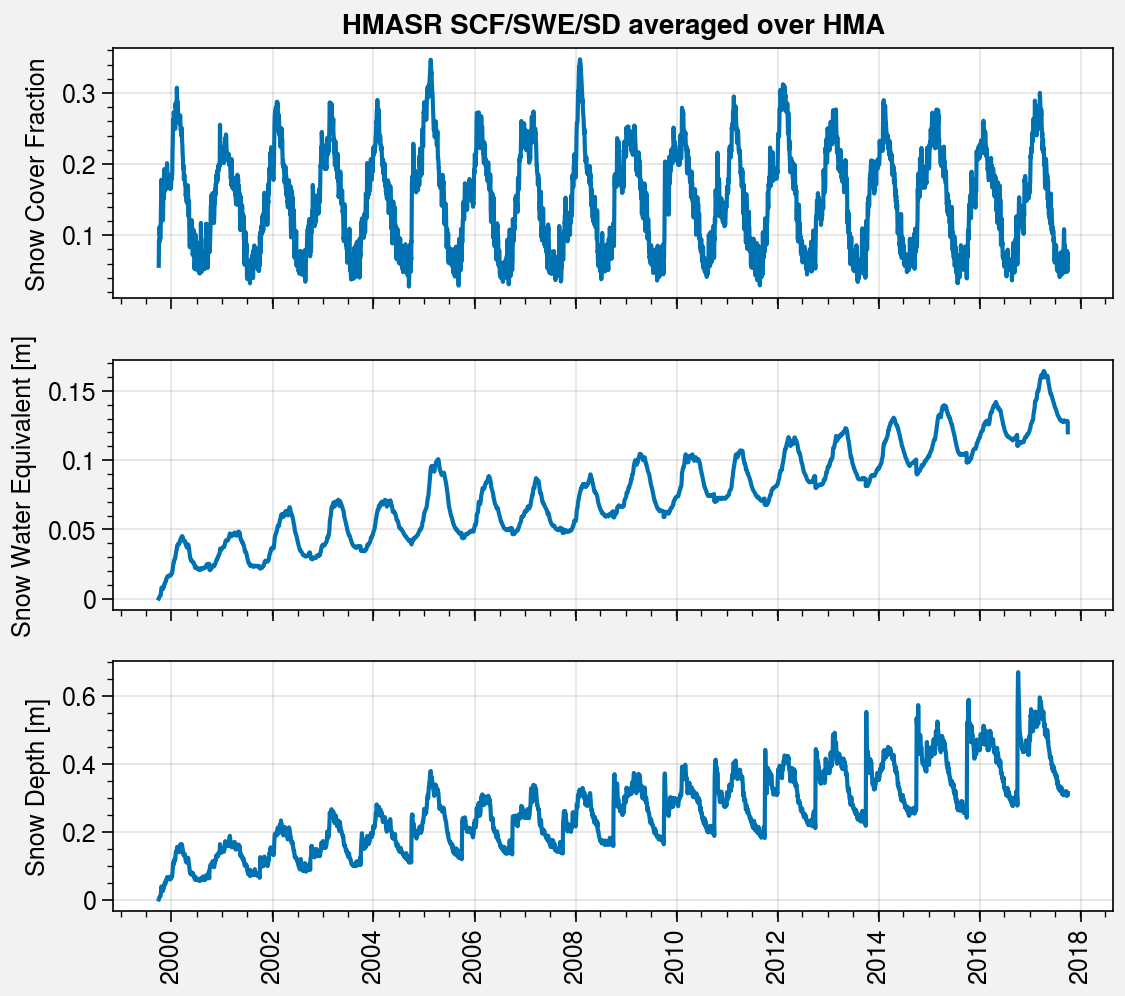

In [5]:
fig, axs = plot.subplots(nrows=3, axwidth=5, aspect=4, sharey=0)

# SCF
ax = axs[0]
ax.plot(sca_ts)
ax.format(
    ylabel='Snow Cover Fraction'
)

# SWE
ax = axs[1]
ax.plot(swe_ts)
ax.format(
    ylabel='Snow Water Equivalent [m]'
)

# SD
ax = axs[2]
ax.plot(sd_ts)
ax.format(
    ylabel='Snow Depth [m]'
)

axs.format(
    suptitle='HMASR SCF/SWE/SD averaged over HMA'
)

# fig.save('HMASR_SCF_SWE_SD_1999-2017.jpg')

## Influence of permanent snow

Check `SCF_parameterizations/0_aggregation/HMASR_monthly-Copy1.ipynb` to see without permanent snow

<img src="../0_aggregation/HMASR_SWE_SCF_mask_1999-2002.jpg" width="500"/>

## Try to remove areas where there is permanent snow
The permanent snow mask seems to be the same for all WY

In [3]:
# For parallelisation
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=3, memory_limit='6GB')
client = Client()
client

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38109 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:35551 Dashboard: http://127.0.0.1:38109/status,Cluster Workers: 4 Cores: 12 Memory: 33.33 GB


In [37]:
client.close()

In [4]:
%%time
path='/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY1999_00/'
mask = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_WY1999_00_MASK.nc', parallel=True).Non_seasonal_snow_mask
mask

CPU times: user 7.6 s, sys: 767 ms, total: 8.37 s
Wall time: 19.9 s


<xarray.DataArray 'Non_seasonal_snow_mask' (Longitude: 9900, Latitude: 4050)>
dask.array<concatenate, shape=(9900, 4050), dtype=float32, chunksize=(225, 225), chunktype=numpy.ndarray>
Coordinates:
  * Latitude   (Latitude) float64 27.0 27.01 27.01 27.02 ... 44.99 44.99 45.0
  * Longitude  (Longitude) float64 61.0 61.01 61.01 61.02 ... 105.0 105.0 105.0
Attributes:
    Units:    [-]

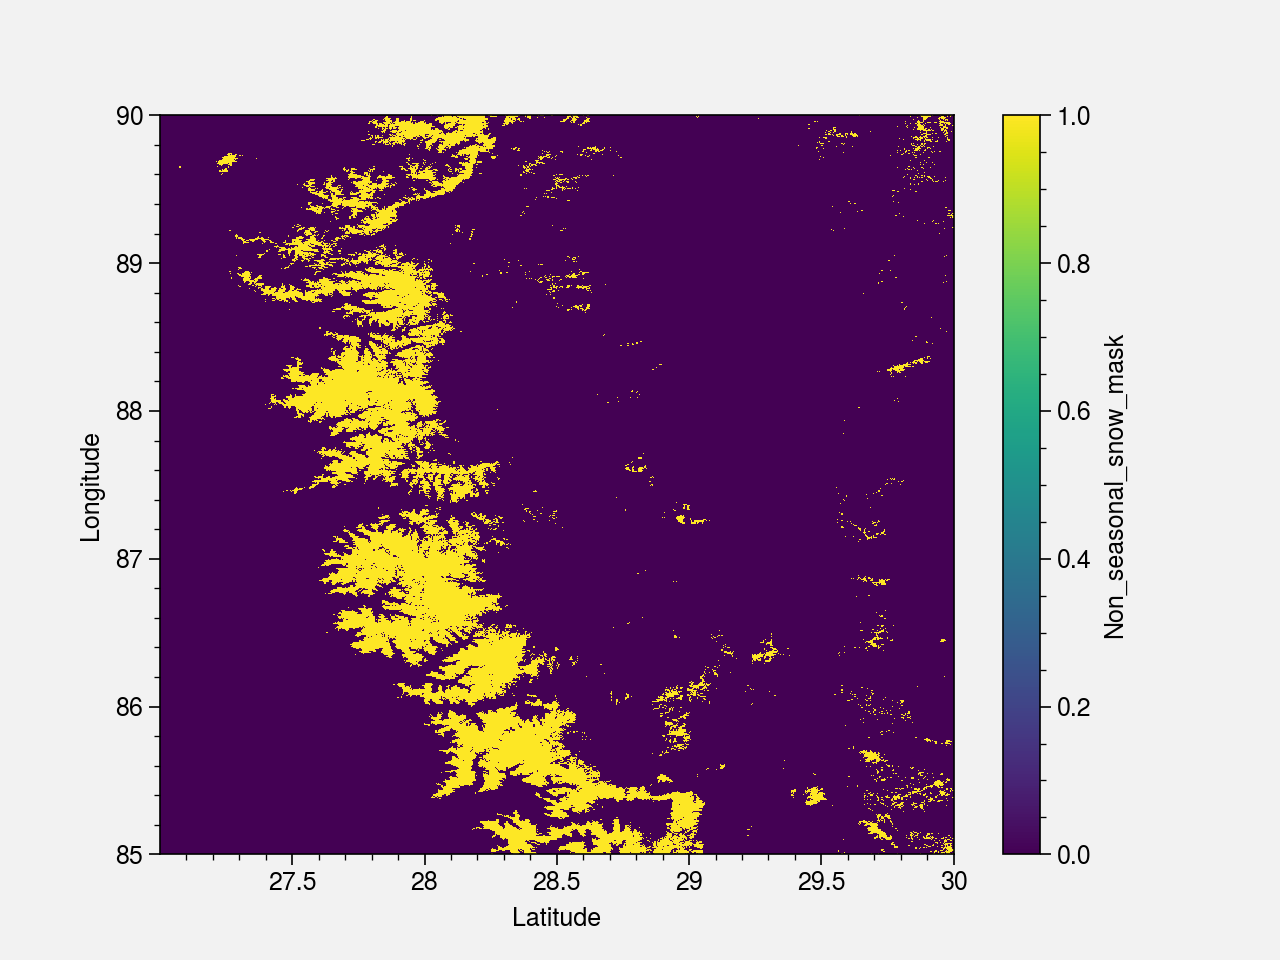

In [5]:
mask_subset = mask.sel(Longitude=slice(85,90), Latitude=slice(27,30)).load()
mask_subset.plot()

In [6]:
permanent_snow_count = mask.coarsen(Latitude=225, Longitude=225).sum().load()
permanent_snow_count = permanent_snow_count.rename({'Longitude': 'lon', 'Latitude': 'lat'}).transpose("lat", "lon")
permanent_snow_count['lat'] = np.round(permanent_snow_count.lat, 1) ; permanent_snow_count['lon'] = np.round(permanent_snow_count.lon, 1)

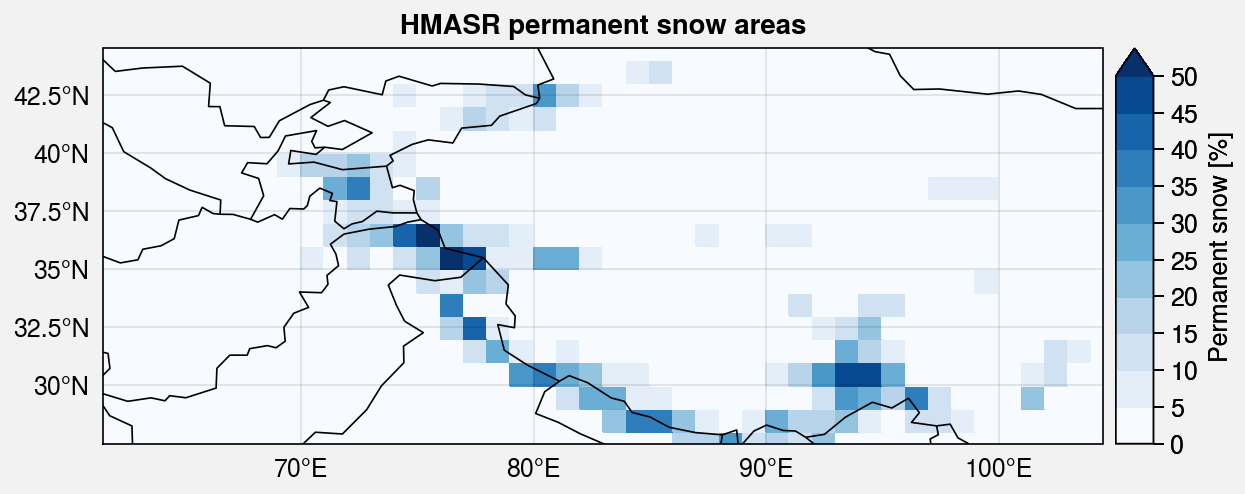

In [66]:
cmap='Blues'
levels=plot.arange(0, 50, 5)
extend='max'

data = (permanent_snow_count/(225*225)*100)

fig, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', axwidth=5, share=0)

ax = axs[0]
ax.pcolormesh(data, colorbar='r', cmap=cmap, levels=levels, extend=extend, 
              colorbar_kw={'label': 'Permanent snow [%]'})
    
# Format   
axs.format(
    suptitle='HMASR permanent snow areas',
    borders=True, labels=True, 
    latlim=(permanent_snow_count.lat.min(), permanent_snow_count.lat.max()), 
    lonlim=(permanent_snow_count.lon.min(), permanent_snow_count.lon.max()),
)

## Load topo

In [78]:
latlim, lonlim = u.get_domain_HMA()
root_data_path = '/home/lalandmi/Dropbox/data/' # local
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

ds = xr.open_dataset(root_data_path+'GMTED2010/GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Check impact of removing permanent snow with a given threshold

In [82]:
mask_psnow = (permanent_snow_count/(225*225)*100)
sd_clim = sd.mean('time')

In [97]:
threshold_list = [20, 10, 5, 0]
['< '+str(i)+' %' for i in threshold_list]

['> 20 %', '> 10 %', '> 5 %', '> 0 %']

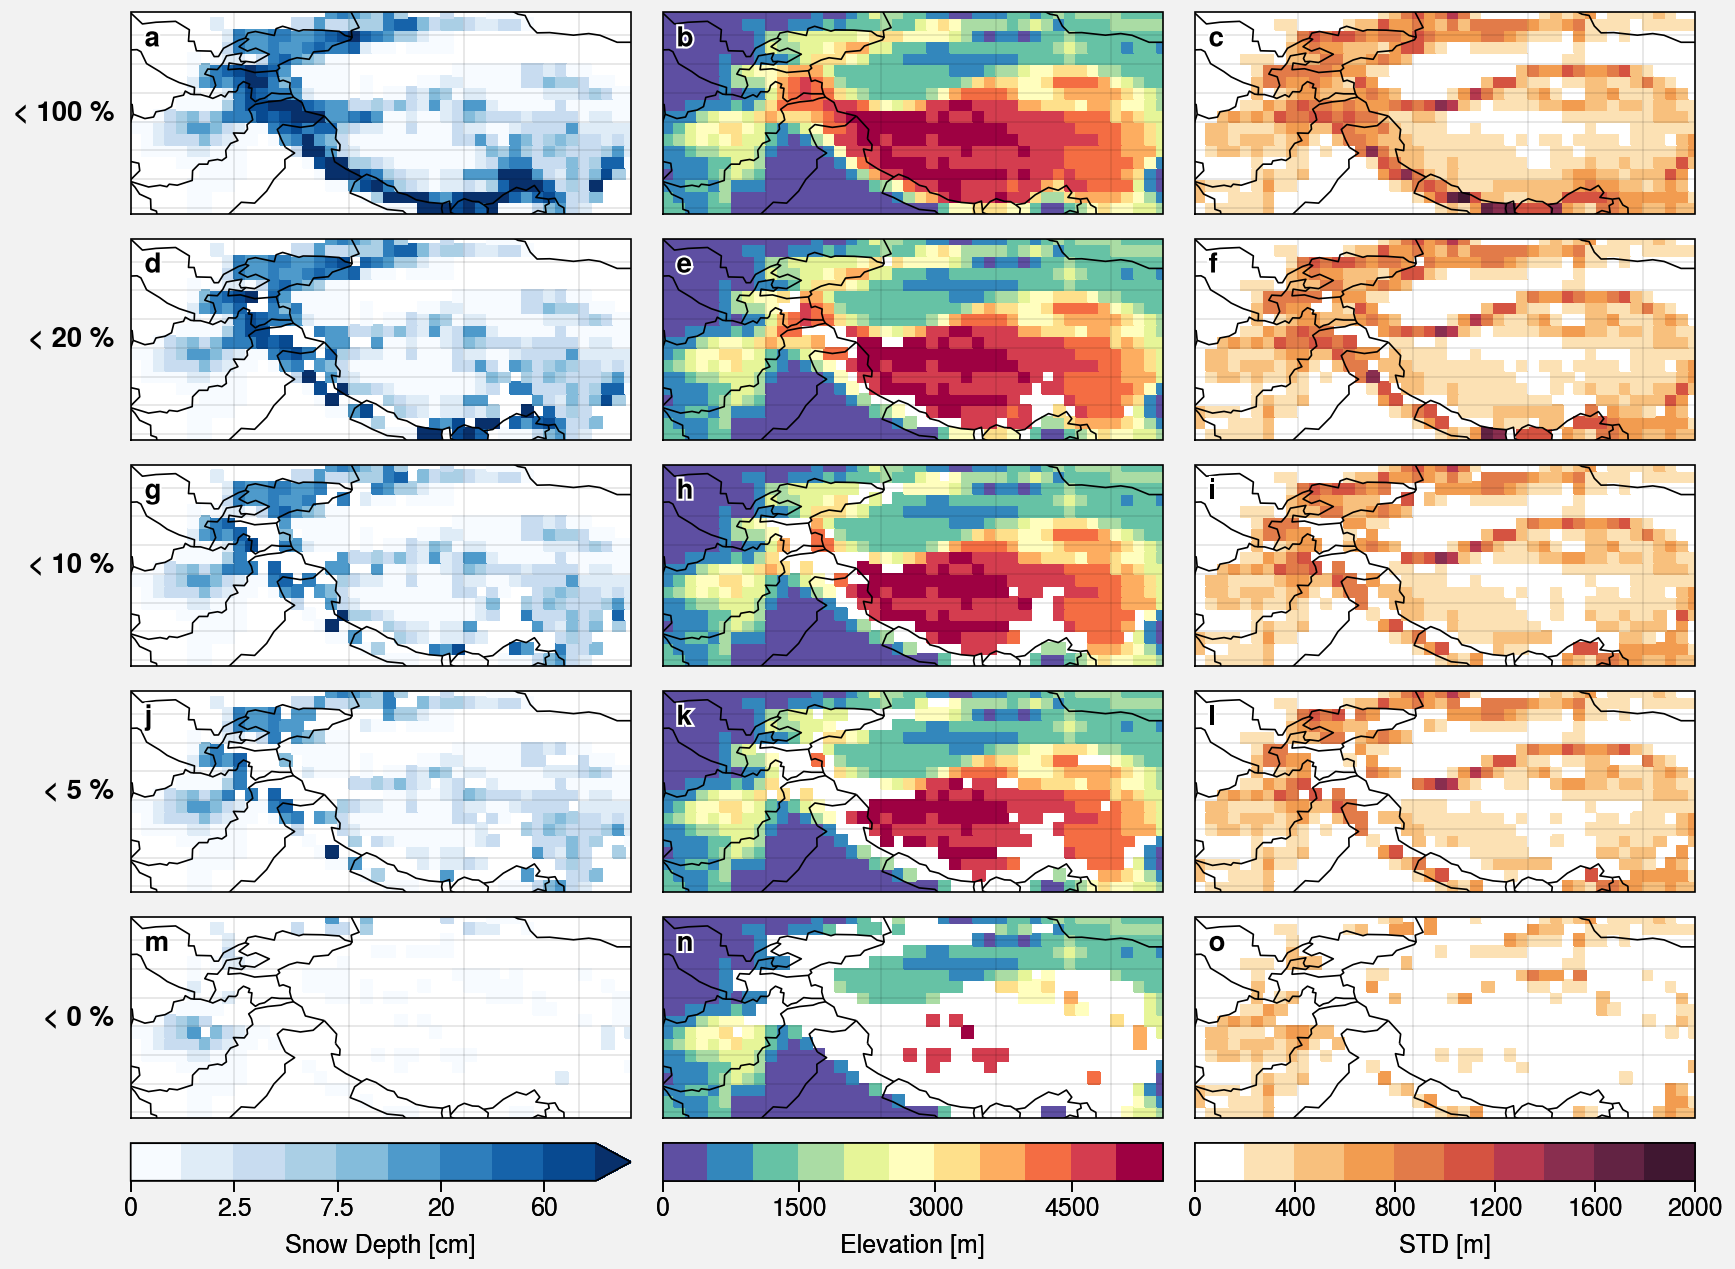

In [102]:
fig, axs = plot.subplots(proj='cyl', ncols=3, nrows=5)

k = 0
threshold_list = [100, 20, 10, 5, 0]
for threshold in threshold_list:
    # Snow Depth
    ax = axs[k]
    m0 = ax.pcolormesh(sd_clim.where(mask_psnow<=threshold)*100, cmap='Blues', levels=[0, 1, 2.5, 5, 7.5, 10, 20, 40, 60, 80], extend='max')
    k += 1
    
    # Elevation
    ax = axs[k]
    m1= ax.pcolormesh(elevation.where(mask_psnow<=threshold), cmap='Spectral_r', levels=plot.arange(0, 5500, 500))
    k += 1

    # STD
    ax = axs[k]
    m2 = ax.pcolormesh(elevation_std.where(mask_psnow<=threshold), levels=plot.arange(0, 2000, 200))
    k += 1               

fig.colorbar(m0, label='Snow Depth [cm]', loc='b', col=1)
fig.colorbar(m1, label='Elevation [m]', loc='b', col=2)
fig.colorbar(m2, label='STD [m]', loc='b', col=3)

# Format
axs.format(
#     suptitle='HMASR permanent snow areas',
    borders=True, labels=False, 
    latlim=(permanent_snow_count.lat.min()-0.5, permanent_snow_count.lat.max()), 
    lonlim=(permanent_snow_count.lon.min()-0.5, permanent_snow_count.lon.max()),
    abc=True, abcloc='ul',
    rowlabels=['< '+str(i)+' %' for i in threshold_list]
)




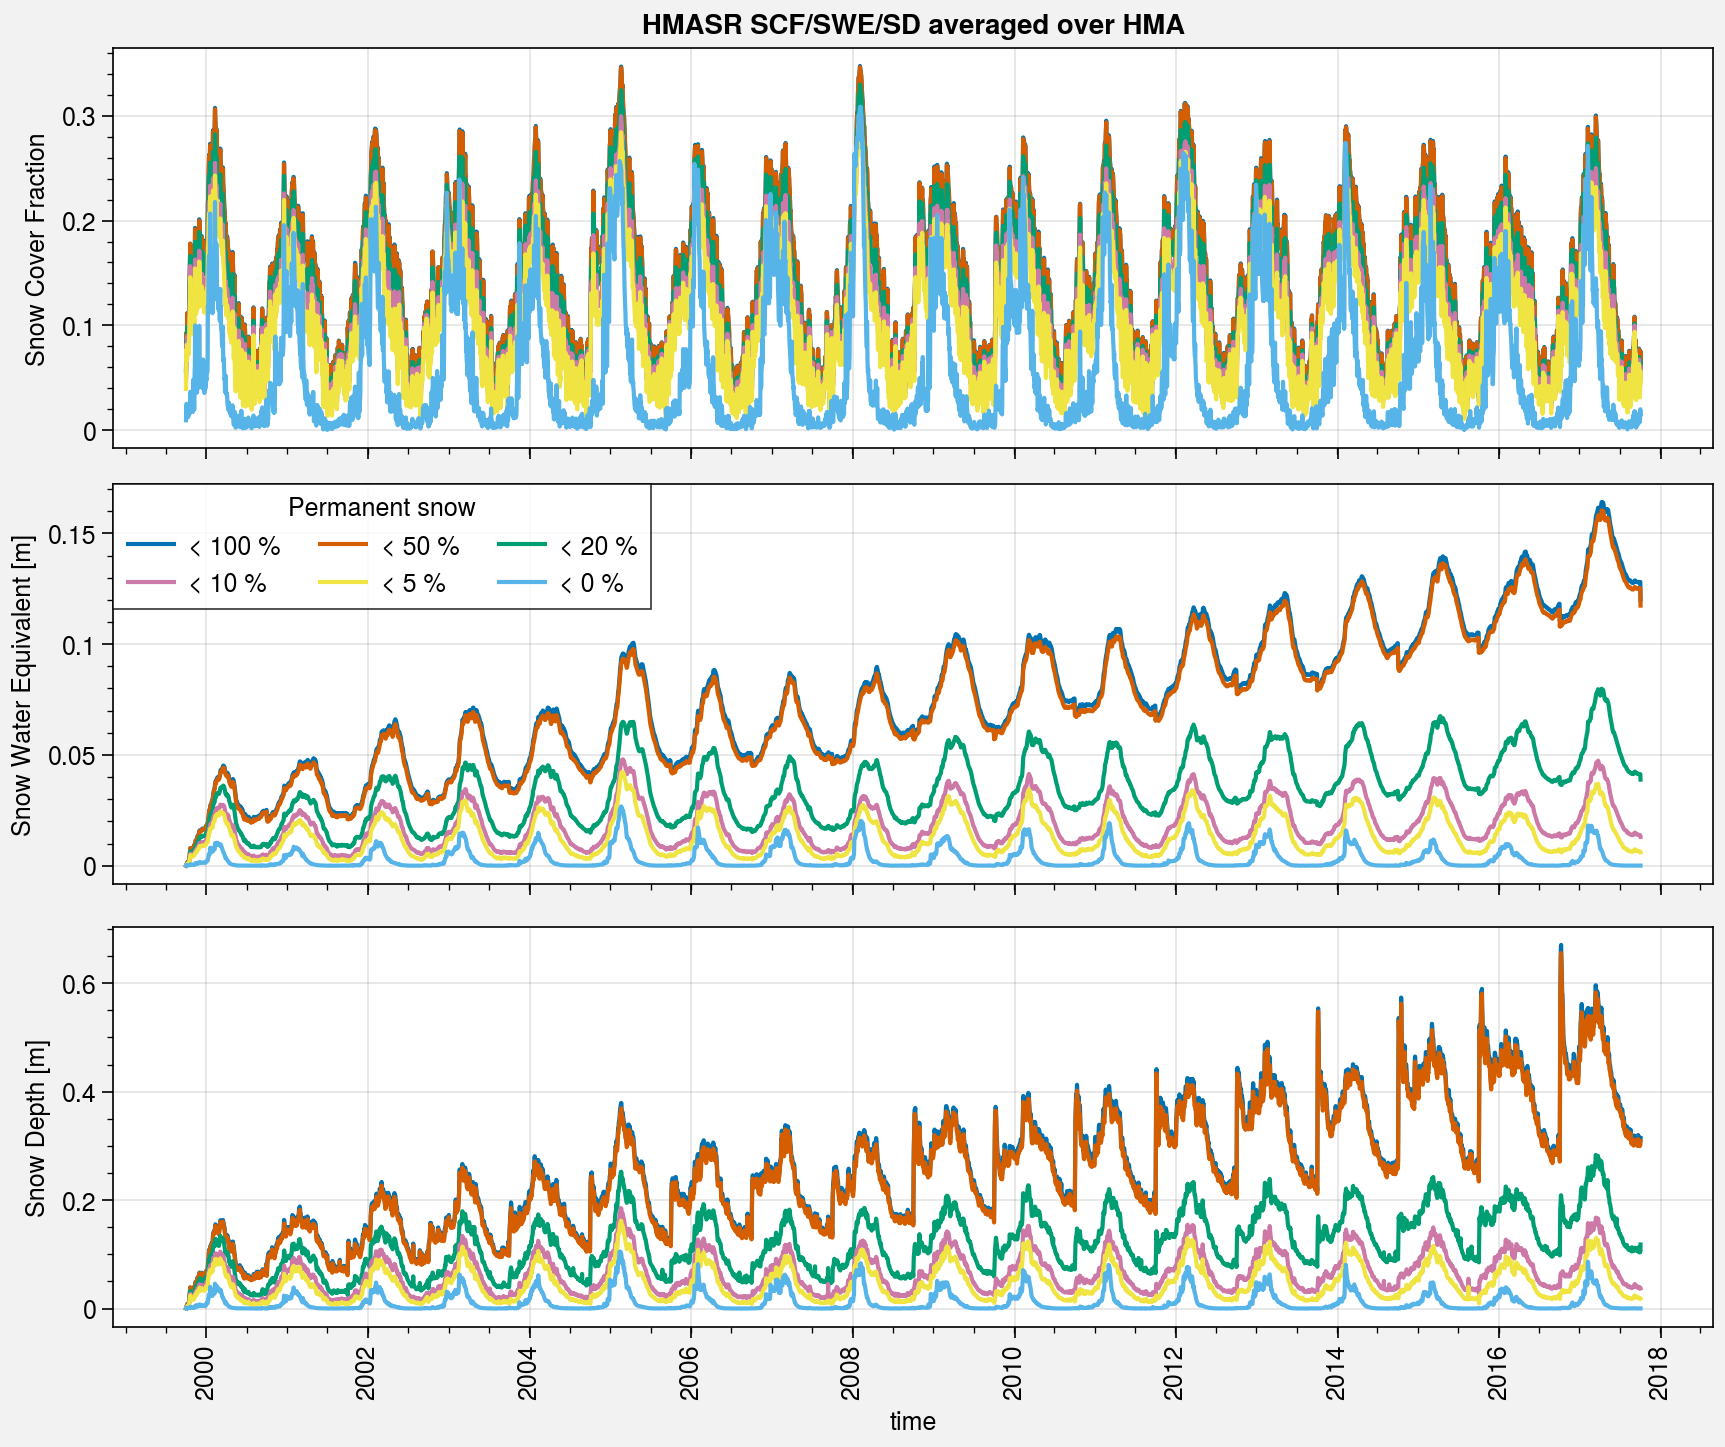

In [77]:
fig, axs = plot.subplots(nrows=3, axwidth=8, aspect=4, sharey=0)

for threshold in [100, 50, 20, 10, 5, 0]:
    # SCF
    ax = axs[0]
    ax.plot(u.spatial_average(sca.where(data<=threshold)))
    ax.format(
        ylabel='Snow Cover Fraction'
    )

    # SWE
    ax = axs[1]
    ax.plot(u.spatial_average(swe.where(data<=threshold)), label='< '+str(threshold)+' %')
    ax.format(
        ylabel='Snow Water Equivalent [m]'
    )

    # SD
    ax = axs[2]
    ax.plot(u.spatial_average(sd.where(data<=threshold)))
    ax.format(
        ylabel='Snow Depth [m]'
    )

axs[1].legend(label='Permanent snow')
    
axs.format(
    suptitle='HMASR SCF/SWE/SD averaged over HMA'
)

# fig.save('HMASR_SCF_SWE_SD_1999-2017.jpg')

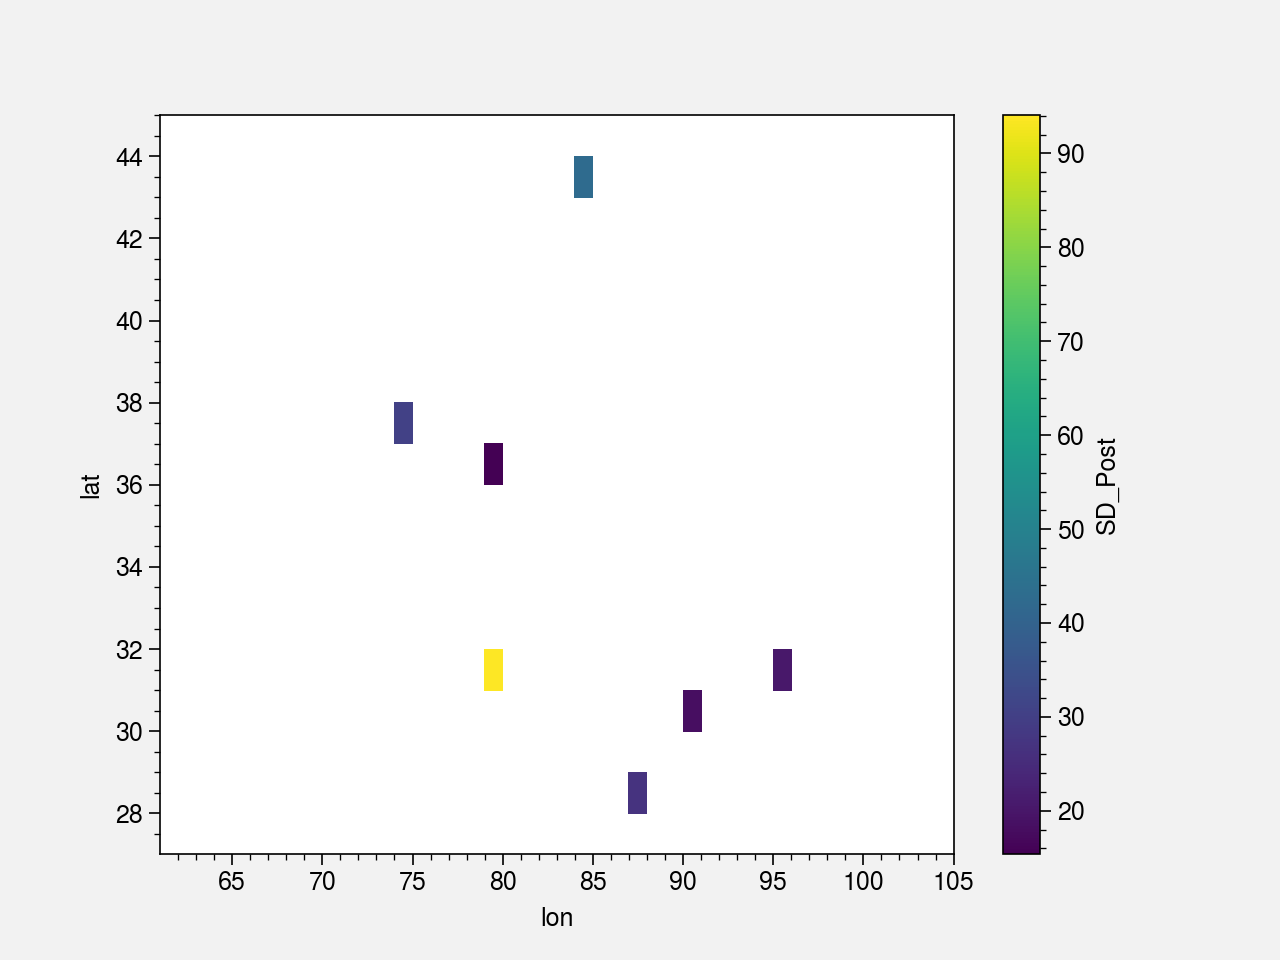

In [120]:
(sd_clim.where((mask_psnow<=10) & (mask_psnow>=9))*100).plot()

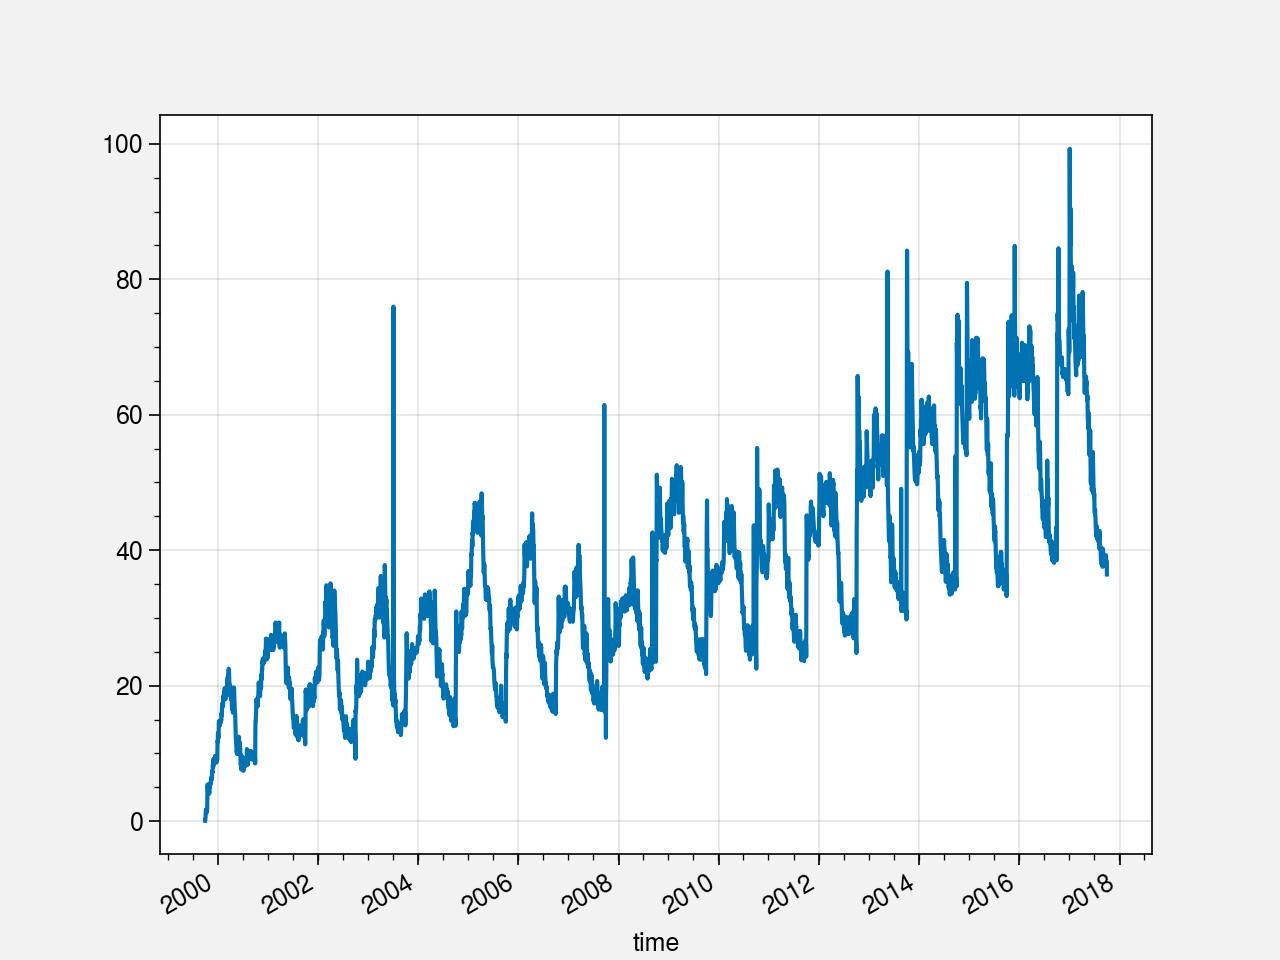

In [123]:
u.spatial_average(sd.where((mask_psnow<=10) & (mask_psnow>=9))*100).plot()

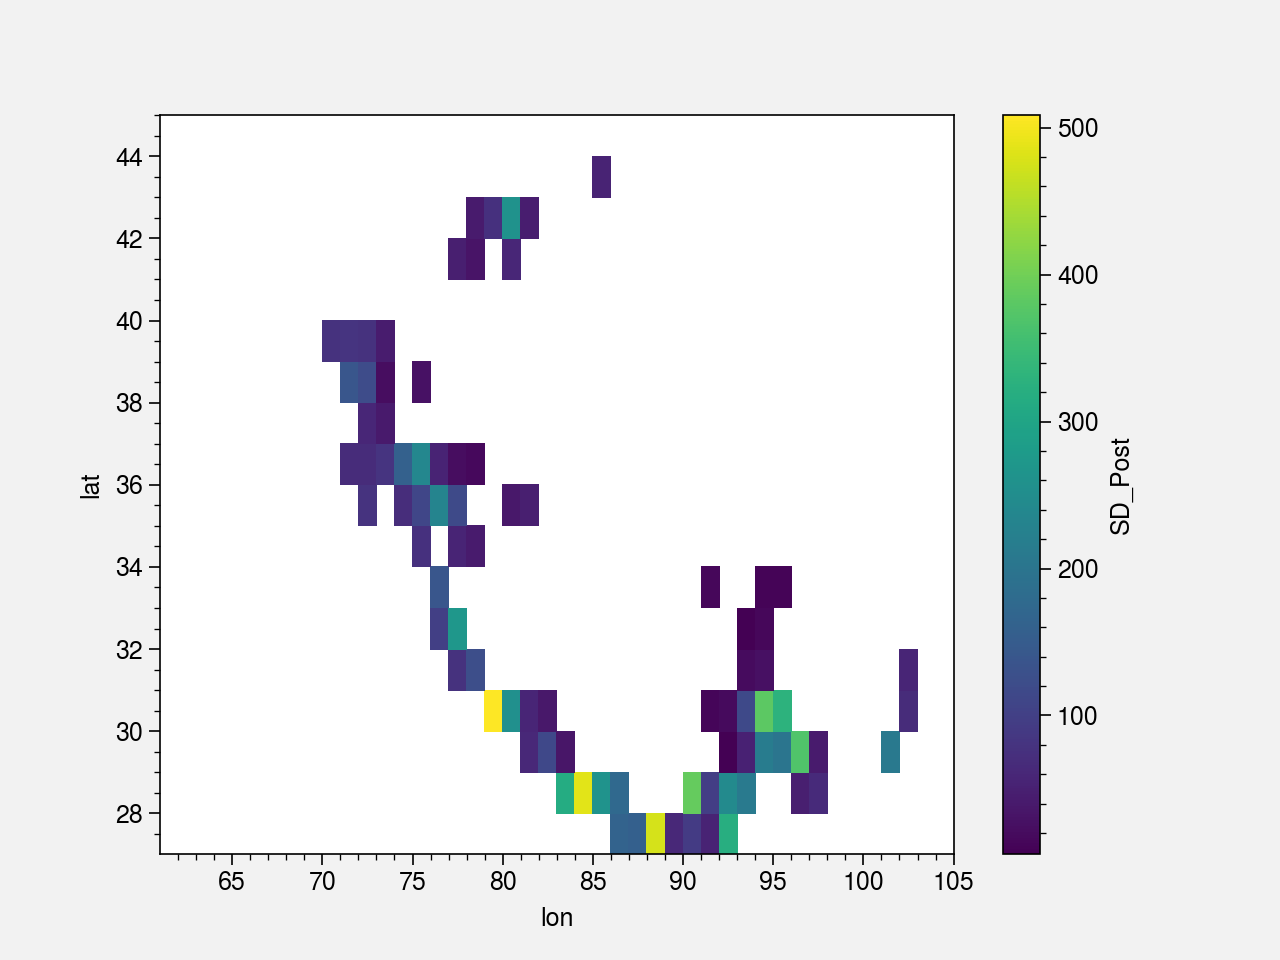

In [112]:
(sd_clim.where((mask_psnow>10))*100).plot()

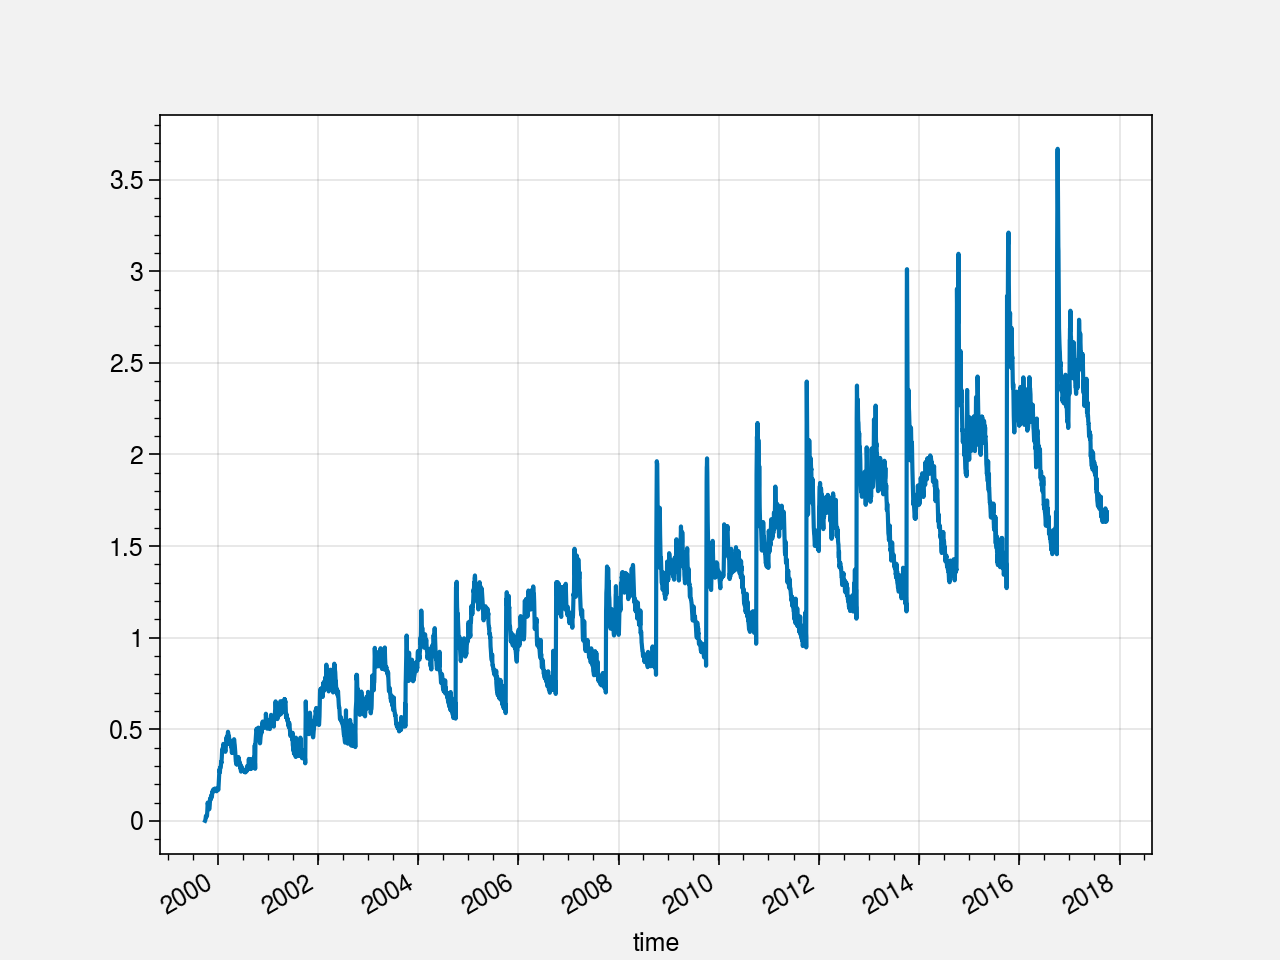

In [114]:
u.spatial_average(sd.where((mask_psnow>=10)*100)).plot()